# Intro

This notebook is used to test the different patterns in the synthetic data generated.

These might include:
- Overall Churn Rate
- Different churn patterns
- Reactivation rates for churning customers

These are an attempt to generate more realistic data.

In [1]:
# Imports
import pandas as pd
from faker import Faker
from faker.providers import DynamicProvider
import numpy as np
import random
from datetime import datetime

In [2]:
# Create a Faker object
fake = Faker(use_weighting=True, locale='en_US', include_private=False)

# Set the seed
Faker.seed(4242)

In [ ]:
# 
devices = ['Tablet', 'Mobile', 'Desktop']

devices_weights = [0.05, 0.8, 0.15]

prefered_device_provider = DynamicProvider(provider_name='prefered_device',
                                  elements=random.choices(devices, devices_weights, k=len(devices)))


state_populations = {
    'California': 39538223,
    'Texas': 29145505,
    'Florida': 21538187,
    'New York': 20201249,
    'Pennsylvania': 13002700,
    'Ohio': 11799448,
    'Georgia': 10711908,
    'North Carolina': 1068778,
    'Michigan': 10077331,
    'New Jersey': 9288994,
    'Virginia': 8626207,
    'Washington': 7693612,
    'Arizona': 7151502,
    'Massachusetts': 7029917,
    'Tennessee': 6910840
}

 # Calculate the total population
total_population = sum(state_populations.values())

# Calculate the weights
state_probabilities = {state: population / total_population for state, population in state_populations.items()}

state_probabilities_values = list(state_probabilities.values())

states = list(state_probabilities.keys())

print(state_probabilities_values)
print(states)



### Generate Customer data

In [3]:
# Create empty list to store the data
customers = []

# For the data to be more realistic, we will create custom distributions for some of the parameters

# Define the population of the states
state_populations = {
    'California': 39538223,
    'Texas': 29145505,
    'Florida': 21538187,
    'New York': 20201249,
    'Pennsylvania': 13002700,
    'Ohio': 11799448,
    'Georgia': 10711908,
    'North Carolina': 1068778,
    'Michigan': 10077331,
    'New Jersey': 9288994,
    'Virginia': 8626207,
    'Washington': 7693612,
    'Arizona': 7151502,
    'Massachusetts': 7029917,
    'Tennessee': 6910840
}

 # Calculate the total population
total_population = sum(state_populations.values())

# Calculate the state weights
state_probabilities = {state: population / total_population for state, population in state_populations.items()}

states = list(state_probabilities.keys())
state_weights = list(state_probabilities.values())

# Create a custom provider for the state
state_provider = DynamicProvider(provider_name='state_provider',
                                  elements=random.choices(states, state_weights, k=len(states)))

# Add the provider to the class
fake.add_provider(state_provider)

# Define the devices and their weights
devices = ['Tablet', 'Mobile', 'Desktop']
devices_weights = [0.05, 0.8, 0.15]

# Create a custom provider for the prefered device
prefered_device= DynamicProvider(provider_name='prefered_device',
                                  elements=random.choices(devices, devices_weights, k=len(devices)))

# Add the provider to the class
fake.add_provider(prefered_device)

# Parameters for the normal distribution of ages
mean_age = 41.5  
std_dev_age = 12  

# Generate ages from a normal distribution and clip to the desired range
num_customers = 10000
ages = np.random.normal(mean_age, std_dev_age, num_customers)
ages = np.clip(ages, 18, 65).astype(int)

# Set 'today' to the last day of the previous year
today = datetime(year=datetime.today().year - 1, month=12, day=31)

# Convert ages to birth dates
birth_dates = [today - pd.DateOffset(years=age) for age in ages]


# Iterate and generate the data
for _ in range(10000):
    customers.append({
        'id': fake.uuid4(),
        'name': fake.first_name(),
        'last_name': fake.last_name(),
        'gender': fake.random_element(elements=('M', 'F')),
        'email': fake.email(),
        'prefered_device': fake.prefered_device(),
        'registration_date': fake.date_between(start_date='-1y', end_date=today),  # Adjust end_date here as well
        'birth_date': birth_dates[_], 
        'street_address': fake.street_address(),
        'city': fake.city(),
        'state': fake.state_provider(),
        'country': 'USA',
        'email_opt_in': fake.boolean(chance_of_getting_true=40)
    })
        
# Save the data to a DataFrame
customers_df = pd.DataFrame(customers)

# Export the csv file 
customers_df.to_csv('../data/customers_test.csv', index=False)

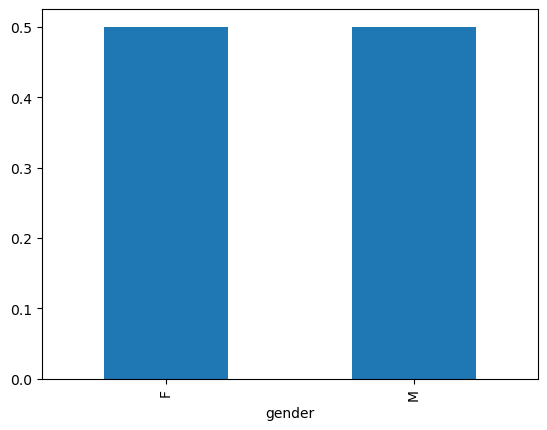

In [4]:
# Check the distribution of gender
customers_df['gender'].value_counts(normalize=True).plot(kind='bar');

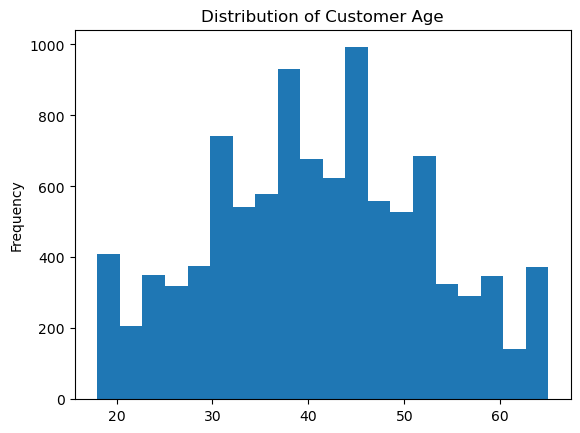

In [5]:
# Calculate customer age
customers_df['age'] = (today - customers_df['birth_date']) / pd.Timedelta(days=365.25)

# Plot the distribution of customer age
customers_df['age'].plot(kind='hist', bins=20, title='Distribution of Customer Age');

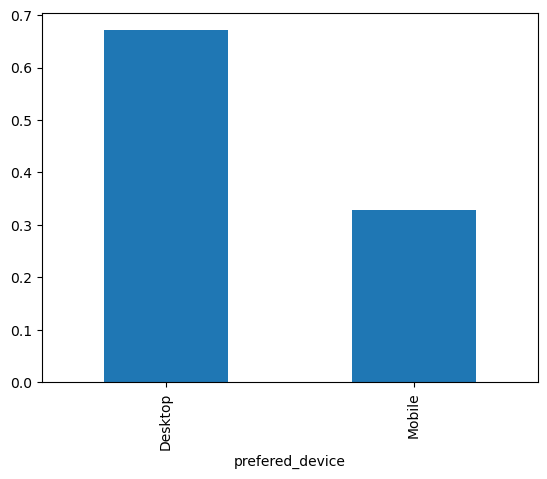

In [7]:
# Check the distribution of the prefered device
customers_df['prefered_device'].value_counts(normalize=True).plot(kind='bar');

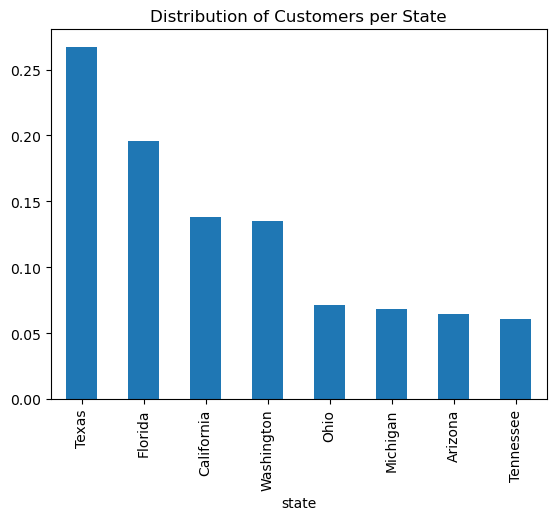

In [8]:
customers_df['state'].value_counts(normalize=True).plot(kind='bar', title='Distribution of Customers per State');

The distribution for these variables now are more realistic

### Generate sales data with churn patterns

This is a simple implementation with 2 types of churn patterns:
1. Sudden churn: the customer randomly churns without a prior decrease in sales
2. Gradual churn: the customer's purchases linearly decrease until they churn

In [ ]:
# Now, lets create sales data with churn patterns

# Import the customers data
customers_df = pd.read_csv('../data/customers_test.csv')


# Define churn parameters
churn_rate = 0.20  # Overall churn rate (20%)
sudden_churn_rate = 0.3 # 30% of churns are sudden

# Assign churn behavior to customers
customers_df['churn_type'] = np.random.choice(
    ['no_churn', 'sudden_churn', 'gradual_churn'],
    p=[1 - churn_rate, sudden_churn_rate * churn_rate, (1 - sudden_churn_rate) * churn_rate],
    size=len(customers_df)
)

start_date = pd.to_datetime('2023-01-01')
end_date = pd.to_datetime('2023-12-31')

sales_data = []
for _, customer in customers_df.iterrows():
    churn_month = None
    if customer['churn_type'] == 'sudden_churn':
        churn_month = random.randint(1, 12)  # Randomly assign churn month
    elif customer['churn_type'] == 'gradual_churn':
        churn_month = random.randint(6, 12)  # Churn happens in the latter half of the year

    for month in range(1, 13):
        if churn_month and month >= churn_month:
            break  # Stop generating sales after churn

        num_orders = fake.random_int(min=1, max=10)  # Adjust as needed
        if customer['churn_type'] == 'gradual_churn':
            num_orders = max(0, num_orders - (month - churn_month + 6) // 2)  # Gradually decrease orders

        for _ in range(num_orders):
            order_date = fake.date_between(start_date=start_date + pd.DateOffset(months=month-1),
                                           end_date=start_date + pd.DateOffset(months=month))
            total_amount = fake.random_int(min=10, max=1000)  # Adjust as needed
            sales_data.append({
                'order_id': fake.uuid4(),
                'customer_id': customer['id'],
                'order_date': order_date,
                'total_amount': total_amount
            })

# Drop the churn_type column
customers_df.drop(columns='churn_type', inplace=True)

sales_df = pd.DataFrame(sales_data)

sales_df.head()

### Non linear decline churn

This script implements a non linear function for the decline churn

In [ ]:
# Import the customers data
customers_df = pd.read_csv('../data/customers_test.csv')

# Define churn parameters
churn_rate = 0.20  # Overall churn rate (20%)
sudden_churn_ratio = 0.3  # 30% of churners will be sudden churners
reactivation_rate = 0.05  # 5% of churned customers will reactivate

# Assign churn behavior to customers
customers_df['churn_type'] = np.random.choice(
    ['no_churn', 'sudden_churn', 'gradual_churn'],
    p=[1 - churn_rate, sudden_churn_ratio * churn_rate, (1 - sudden_churn_ratio) * churn_rate],
    size=len(customers_df)
)

# Generate sales data over 12 months
start_date = pd.to_datetime('2023-01-01')
end_date = pd.to_datetime('2023-12-31')

sales_data = []
for _, customer in customers_df.iterrows():
    churn_month = None
    reactivation_month = None
    if customer['churn_type'] == 'sudden_churn':
        churn_month = random.randint(1, 12) 
    elif customer['churn_type'] == 'gradual_churn':
        churn_month = random.randint(3, 12)  # Allow churn to start earlier

    if customer['churn_type'] != 'no_churn' and churn_month is not None:
        reactivation_month = random.randint(churn_month + 1, 12) if churn_month < 12 else None

    for month in range(1, 13):
        if churn_month and month >= churn_month and (not reactivation_month or month < reactivation_month):
            continue  # Skip months during churn period (unless reactivated)

        num_orders = fake.random_int(min=1, max=5)
        if customer['churn_type'] == 'gradual_churn':
            decline_factor = max(0, 1 - 0.2 * ((month - churn_month + 3) // 3))  # Non-linear decline
            num_orders = int(num_orders * decline_factor)

        for _ in range(num_orders):
            order_date = fake.date_between(start_date=start_date + pd.DateOffset(months=month-1),
                                           end_date=start_date + pd.DateOffset(months=month))
            total_amount = fake.random_int(min=10, max=200)
            sales_data.append({
                'order_id': fake.uuid4(),
                'customer_id': customer['id'],
                'order_date': order_date,
                'total_amount': total_amount
            })


# Drop the churn_type column
customers_df.drop(columns='churn_type', inplace=True)

sales_df_2 = pd.DataFrame(sales_data)

sales_df_2.head()

### Churn with multiple decline functions

This implementation mixes different patterns of decline churn:
- Exponential decline
- Logarithmic decline
- Step wise decline

In [6]:
# Define the functions

# Exponential decline
def exponential_decline(month, churn_month, decay_rate=0.2):
    """
    Calculates the exponential decline factor for a given month, churn month, and decay rate.
    Parameters:
    - month (int): The current month.
    - churn_month (int): The month when the decline starts.
    - decay_rate (float): The rate at which the decline occurs. Default is 0.2.
    Returns:
    - float: The exponential decline factor for the given month.
    """
    
    if month < churn_month:
        return 1 # No decline before churn
    else:
        time_since_churn = month - churn_month + 1
        return np.exp(-decay_rate * time_since_churn)
    
# Logarithmic decline
def logarithmic_decline(month, churn_month, base=2):
    """
    Calculates the logarithmic decline factor for a given month, churn month, and base.
    Parameters:
    - month (int): The current month.
    - churn_month (int): The month when the decline starts.
    - base (int): The base of the logarithm. Default is 2.
    Returns:
    - float: The logarithmic decline factor for the given month.
    """
    
    if month < churn_month:
        return 1 # No decline before churn
    else:
        time_since_churn = month - churn_month + 1
        return 1 / np.log2(base * time_since_churn)
    
# Step wise decline
def stepwise_decline(month, churn_month, step_size=3):
    """
    Calculates the step-wise decline factor for a given month, churn month, and step size.
    Parameters:
    - month (int): The current month.
    - churn_month (int): The month when the decline starts.
    - step_size (int): The number of months between steps. Default is 3.
    Returns:
    - float: The step-wise decline factor for the given month.
    """
    
    if month < churn_month:
        return 1 # No decline before churn
    else:
       steps_since_churn = (month - churn_month) // step_size
       return decline_factor ** steps_since_churn

In [ ]:
# Define churn parameters
churn_rate = 0.20  # Overall churn rate (20%)
sudden_churn_ratio = 0.3  # 30% of churners will be sudden churners
reactivation_rate = 0.05  # 5% of churned customers will reactivate

# Assign churn behavior to customers
customers_df['churn_type'] = np.random.choice(
    ['no_churn', 'sudden_churn', 'gradual_churn'],
    p=[1 - churn_rate, sudden_churn_ratio * churn_rate, (1 - sudden_churn_ratio) * churn_rate],
    size=len(customers_df)
)

gradual_churners = customers_df[customers_df['churn_type'] == 'gradual_churn']
gradual_churners['churn_pattern'] = np.random.choice(
    ['exponential', 'logarithmic', 'stepwise'],
    size=len(gradual_churners)
)

customers_df.update(gradual_churners)

# Generate sales data over 12 months
start_date = pd.to_datetime('2023-01-01')
end_date = pd.to_datetime('2023-12-31')

sales_data = []
for _, customer in customers_df.iterrows():
    # Assign a random first_order_month between 1 and 12
    first_order_month = random.randint(1, 12)

    churn_month = None
    reactivation_month = None
    
    if customer['churn_type'] == 'sudden_churn':
        # Churn cannot be the first month
        churn_month = random.randint(max(2, first_order_month), 12) 
    elif customer['churn_type'] == 'gradual_churn':
        # Churn cannot be the first 3 months
        churn_month = random.randint(max(3, first_order_month), 12)

        if customer['churn_type'] != 'no_churn' and churn_month < 12:
            reactivation_month = random.randint(churn_month + 1, 12)

        for month in range(1, 13):
            if month < first_order_month:
                continue # Skip months before the first order

            if churn_month and month >= churn_month and (not reactivation_month or month < reactivation_month):
                continue 

            num_orders = fake.random_int(min=1, max=10)

            # Check if 'churn_pattern' exists before accessing it
            if 'churn_pattern' in customer:
                if customer['churn_pattern'] == 'stepwise':
                    decline_factor = stepwise_decline(month, churn_month, step_size=3)
                elif customer['churn_pattern'] == 'logarithmic':
                    decline_factor = logarithmic_decline(month, churn_month, base=2)
                elif customer['churn_pattern'] == 'exponential':
                    decline_factor = exponential_decline(month, churn_month, decay_rate=0.2)
                else:
                    raise ValueError("Invalid churn pattern")

                num_orders = int(num_orders * decline_factor) 

            for _ in range(num_orders):
                order_date = fake.date_between(start_date=start_date + pd.DateOffset(months=month-1),
                                               end_date=start_date + pd.DateOffset(months=month))
                total_amount = fake.random_int(min=10, max=2000)
                sales_data.append({
                    'order_id': fake.uuid4(),
                    'customer_id': customer['id'],
                    'order_date': order_date,
                    'total_amount': total_amount
                })

# Drop the churn_type column
customers_df.drop(columns='churn_type', inplace=True)

sales_df_3 = pd.DataFrame(sales_data)

# Check the first few rows of the sales data
sales_df_3.head()
